Loading data from video_info.csv...
Initial DataFrame shape: (41, 15)
Columns: ['filename', 'duration_seconds', 'fps', 'width', 'height', 'num_frames', 'file_size_MB', 'codec', 'has_audio', 'audio_fps', 'audio_channels', 'title', 'publish_time', 'likes', 'embedding']

Checking for missing values...
No missing values found.

Expanding 'embedding' column...
Embedding size: 32768
Expanded 'embedding' into 32768 separate columns.

Dropping non-numeric or irrelevant columns...
Dropped column: filename
Dropped column: title
Dropped column: publish_time

Encoding categorical variables...
One-hot encoded 'codec' column.
Mapped 'has_audio' to binary.

Ensuring all features are numerical...
duration_seconds    float64
fps                 float64
width                 int64
height                int64
num_frames            int64
                     ...   
embedding_32764     float64
embedding_32765     float64
embedding_32766     float64
embedding_32767     float64
embedding_32768     float64
Le

,Actual Likes,Predicted Likes
0,18,32.92
1,7,30.88
2,25,27.71
3,30,29.72
4,32,26.47
5,14,25.89
6,16,30.25
7,10,28.73
8,15,27.23



Evaluating the model on the testing dataset...
Testing Mean Squared Error (MSE): 186.1872
Testing Root Mean Squared Error (RMSE): 13.6450
Testing R² Score: -1.7918


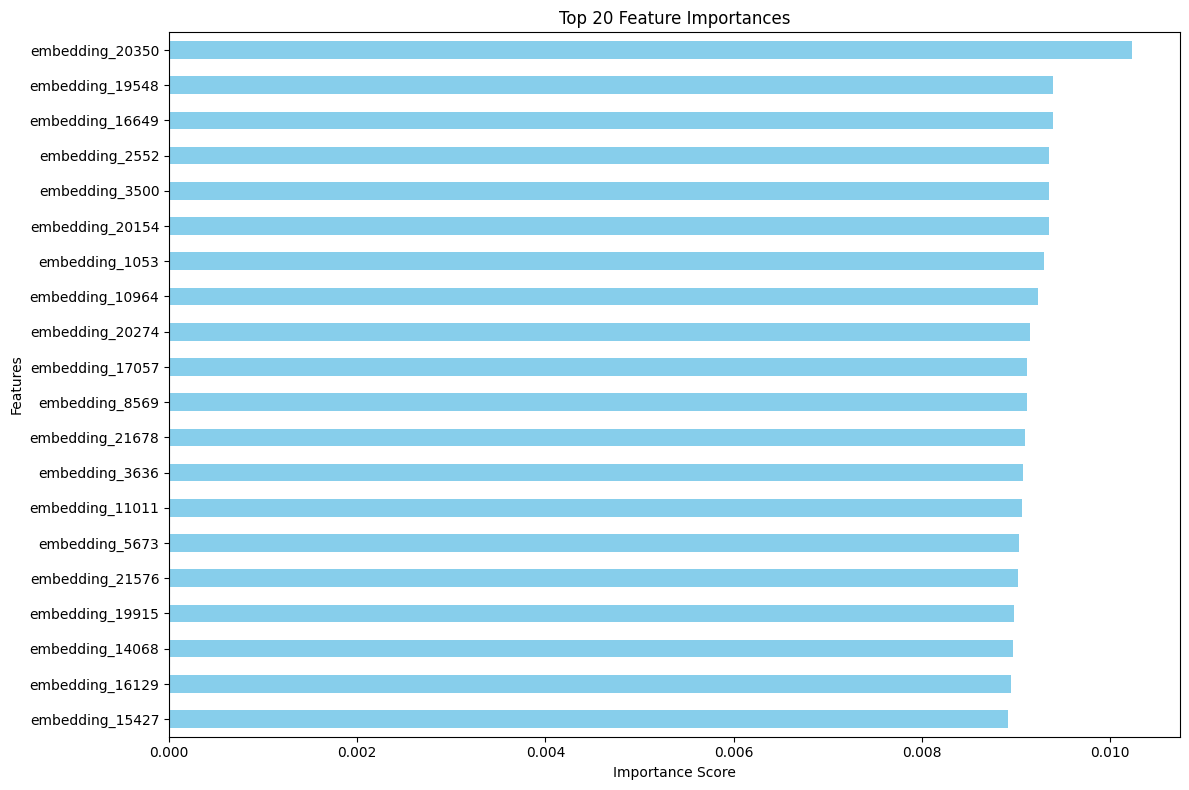

Model saved to video_likes_predictor.joblib


In [39]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

def parse_embedding(embedding_str):
    """
    Parses the embedding string into a list of floats.
    
    Args:
        embedding_str (str): String representation of the embedding list.
    
    Returns:
        list or np.nan: List of floats if parsing is successful, otherwise NaN.
    """
    try:
        # Remove all '[' and ']' characters
        embedding_str = embedding_str.replace('[', '').replace(']', '').strip()
        
        # Split the string by comma
        parts = embedding_str.split(',')
        
        # Convert each part to float
        embedding = [float(part.strip()) for part in parts]
        
        return embedding
    except Exception as e:
        print(f"Error parsing embedding: {e}")
        return np.nan

def load_and_preprocess_data(csv_file):
    """
    Loads the video_info.csv file, expands the embedding column, and preprocesses the data.
    
    Args:
        csv_file (str): Path to the video_info.csv file.
    
    Returns:
        pd.DataFrame: Preprocessed DataFrame ready for modeling.
    """
    # Check if the file exists
    if not os.path.isfile(csv_file):
        raise FileNotFoundError(f"The file {csv_file} does not exist.")
    
    # Load the CSV
    print(f"Loading data from {csv_file}...")
    df = pd.read_csv(csv_file)
    
    # Display initial information
    print("Initial DataFrame shape:", df.shape)
    print("Columns:", df.columns.tolist())
    
    # Check for missing values
    print("\nChecking for missing values...")
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(missing_values[missing_values > 0])
    else:
        print("No missing values found.")
    
    # Handle missing values if any (simple approach: drop rows with missing target)
    if 'likes' in df.columns and df['likes'].isnull().sum() > 0:
        df = df.dropna(subset=['likes'])
        print("Dropped rows with missing 'likes' values.")
    
    # Expand the 'embedding' column into separate columns
    if 'embedding' in df.columns:
        print("\nExpanding 'embedding' column...")
        # Apply the parsing function
        df['embedding_parsed'] = df['embedding'].apply(parse_embedding)
        
        # Drop rows where parsing failed
        initial_shape = df.shape
        df = df.dropna(subset=['embedding_parsed'])
        if df.shape != initial_shape:
            print(f"Dropped {initial_shape[0] - df.shape[0]} rows due to embedding parse errors.")
        
        # Determine the embedding size
        if not df.empty:
            embedding_size = len(df['embedding_parsed'].iloc[0])
            print(f"Embedding size: {embedding_size}")
            
            # Create separate columns for each embedding dimension
            embedding_columns = [f'embedding_{i+1}' for i in range(embedding_size)]
            embedding_df = pd.DataFrame(df['embedding_parsed'].tolist(), columns=embedding_columns)
            
            # Concatenate the embeddings with the original DataFrame
            df = pd.concat([df.drop(['embedding', 'embedding_parsed'], axis=1), embedding_df], axis=1)
            print(f"Expanded 'embedding' into {embedding_size} separate columns.")
        else:
            print("Error: No data left after parsing embeddings.")
            raise ValueError("No valid embeddings found in the data.")
    else:
        print("Error: 'embedding' column not found in the CSV.")
        raise ValueError("The 'embedding' column is missing.")
    
    # Optional: Drop columns that are not useful for prediction
    # For example, 'filename', 'title', 'publish_time' might be dropped or processed differently
    # Here, we'll keep all numerical features and drop 'title' and 'publish_time'
    print("\nDropping non-numeric or irrelevant columns...")
    columns_to_drop = ['filename', 'title', 'publish_time']
    for col in columns_to_drop:
        if col in df.columns:
            df = df.drop(col, axis=1)
            print(f"Dropped column: {col}")
    
    # Convert categorical columns to numerical if any
    # In your features, 'codec' and 'has_audio' are categorical
    # We'll use one-hot encoding for 'codec' and map 'has_audio' to binary
    print("\nEncoding categorical variables...")
    if 'codec' in df.columns:
        df = pd.get_dummies(df, columns=['codec'], drop_first=True)
        print("One-hot encoded 'codec' column.")
    if 'has_audio' in df.columns:
        df['has_audio'] = df['has_audio'].map({True: 1, False: 0})
        print("Mapped 'has_audio' to binary.")
    
    # Check for any remaining object-type columns
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    if object_columns:
        print("\nWarning: The following columns have object type and may need encoding or removal:", object_columns)
    
    # Ensure all features are numerical
    print("\nEnsuring all features are numerical...")
    print(df.dtypes)
    
    return df

def train_and_evaluate_model(X_train, y_train):
    """
    Trains a regression model to predict 'likes' using the training dataset and evaluates its performance.
    
    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
    
    Returns:
        model: Trained regression model.
        feature_importances (pd.Series): Feature importances from the model.
        metrics_train (dict): Evaluation metrics on the training data.
    """
    # Ensure all features are numerical
    if not all([pd.api.types.is_numeric_dtype(dtype) for dtype in X_train.dtypes]):
        print("\nWarning: Some features are not numerical. They will be converted if possible.")
        # Attempt to convert non-numeric features to numeric
        X_train = X_train.apply(pd.to_numeric, errors='coerce')
        # Check again for non-numeric columns
        non_numeric = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
        if non_numeric:
            print(f"Error: The following features are still non-numeric and need to be handled: {non_numeric}")
            raise ValueError("Non-numeric features present in the data.")
    
    # Handle any remaining missing values by imputing or dropping
    print("\nHandling missing values in training features...")
    if X_train.isnull().sum().sum() > 0:
        # Optionally, fill missing values with mean
        X_train = X_train.fillna(X_train.mean())
        print("Filled missing values with mean.")
    
    # Initialize the model
    print("\nInitializing the Random Forest Regressor...")
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1  # Utilize all available cores
    )
    
    # Train the model on the training dataset
    print("Training the model on the training dataset...")
    model.fit(X_train, y_train)
    
    # Predict on the training dataset
    print("Making predictions on the training dataset...")
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model on the training dataset
    print("\nEvaluating the model on the training dataset...")
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    print(f"Training Mean Squared Error (MSE): {mse_train:.4f}")
    print(f"Training Root Mean Squared Error (RMSE): {rmse_train:.4f}")
    print(f"Training R² Score: {r2_train:.4f}")
    
    # Get feature importances
    print("\nExtracting feature importances...")
    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
    
    # Compile evaluation metrics
    metrics_train = {
        'MSE': mse_train,
        'RMSE': rmse_train,
        'R2_Score': r2_train
    }
    
    return model, feature_importances, metrics_train

def plot_feature_importances(feature_importances, top_n=20):
    """
    Plots the top N feature importances as a bar chart.
    
    Args:
        feature_importances (pd.Series): Feature importances sorted in descending order.
        top_n (int): Number of top features to display.
    """
    plt.figure(figsize=(12, 8))
    feature_importances.head(top_n).sort_values().plot(kind='barh', color='skyblue')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

def save_model(model, filename='video_likes_predictor.joblib'):
    """
    Saves the trained model to a file using joblib.
    
    Args:
        model: Trained machine learning model.
        filename (str): Filename to save the model.
    """
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

def load_model(filename='video_likes_predictor.joblib'):
    """
    Loads the trained model from a file.
    
    Args:
        filename (str): Path to the saved model file.
    
    Returns:
        Loaded model.
    """
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"The model file {filename} does not exist.")
    model = joblib.load(filename)
    print(f"Model loaded from {filename}")
    return model

def main():
    # Step 1: Load and preprocess data
    data = load_and_preprocess_data('video_info.csv')
    
    # Define target and features
    target = 'likes'
    features = data.columns.tolist()
    if target not in features:
        raise ValueError(f"Target column '{target}' not found in the DataFrame.")
    features.remove(target)
    
    # Separate features and target
    X = data[features]
    y = data[target]
    
    # Split data into training and testing sets (80-20 split)
    print("\nSplitting data into training and testing sets (80-20 split)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")
    
    # Step 2: Train and evaluate the model on training data
    model, feature_importances, metrics_train = train_and_evaluate_model(X_train, y_train)
    
    # Step 3: Use the model to predict on the testing dataset
    print("\nMaking predictions on the testing dataset...")
    y_pred_test = model.predict(X_test)
    
    # Step 4: Create and display a DataFrame of Actual vs Predicted Likes
    print("\nCreating DataFrame of Actual vs Predicted Likes on Testing Data...")
    results_df = pd.DataFrame({
        'Actual Likes': y_test.values,
        'Predicted Likes': y_pred_test
    }).reset_index(drop=True)
    display(results_df.head(20))  
    
    # # Optionally, save the results to a CSV file
    # results_df.to_csv('actual_vs_predicted_likes_test.csv', index=False)
    # print("Saved Actual vs Predicted Likes on Testing Data to 'actual_vs_predicted_likes_test.csv'")
    
    # Step 5: Evaluate the model on the testing dataset
    print("\nEvaluating the model on the testing dataset...")
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"Testing Mean Squared Error (MSE): {mse_test:.4f}")
    print(f"Testing Root Mean Squared Error (RMSE): {rmse_test:.4f}")
    print(f"Testing R² Score: {r2_test:.4f}")
    
    # Step 6: Plot feature importances
    plot_feature_importances(feature_importances, top_n=20)
    
    # Step 7: Save the trained model
    save_model(model, 'video_likes_predictor.joblib')
    
if __name__ == "__main__":
    main()

